# Predicting Profitability and Popularity of movies
**In this notebook, we are going to build and test different models to:**

**1) Predict which movies would be profitable**

**2) Predict which movies would be popular**

# 1. Importing the libraries and the data that was obtained from the previous notebook - Data-cleaning

In [1]:
%matplotlib inline 
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.cm as cm 
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.tools.plotting import scatter_matrix
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set(style="whitegrid")
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
#from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.formula.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/angps/anaconda3/envs/angps/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
valid_data=pd.read_csv("/home/angps/Documents/DSC3216 (1)/project/valid_data.csv")

In [3]:
valid_data.head(2)

,index,adult,budget,genres,id,original_language,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,top_cast,top_crew,Spring,Summer,Autumn
0,9,False,3512454,['Drama'],110428,fr,"Winter, 1915. Confined by her family to an asy...",0.134014,[],['France'],2013-03-13,115860.0,95.0,NaN,Camille Claudel 1915,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"['Juliette Binoche', 'Robert Leroy']","['Bruno Dumont', 'Bruno Dumont']",1,0,0
1,15,False,40000000,"['Adventure', 'Drama']",77221,en,"On the Arabian Peninsula in the 1930s, two war...",6.652197,[],"['France', 'Italy', 'Qatar', 'Tunisia']",2011-12-21,5446000.0,130.0,NaN,Black Gold,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,"['Mark Strong', 'Antonio Banderas']","['Menno Meyjes', 'James Horner']",0,0,0


# 2) Getting the required variables for regression and classification
**We would drop those non-numerical variables (e.g index,adult,id,overview etc) in order to perform regression and classification**

In [4]:
valid_data_models=valid_data.copy()
valid_data_models.drop(["index","adult","genres","id","original_language","overview","production_companies","production_countries","release_date","tagline","title","top_cast","top_crew"],inplace=True,axis=1)

In [5]:
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


# 3) Inserting profitability and popularity measures
**We use the simple Return-On-Investment (ROI) formula to determine if a movie is profitable. We would require an ROI of at least 2x to be deemed worthy to invest in.**

**We use the weighted ratings formula used by Imdb and will only classify the top 25% of the weighted ratings as movies that are popular.**

In [6]:
#For profitability:
def simple_profit(x):
    return (x["revenue"]-x["budget"])/(x["budget"])

#For popularity:
vote_counts = valid_data_models[valid_data_models['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = valid_data_models[valid_data_models['vote_average'].notnull()]['vote_average'].astype('int')
C = vote_averages.mean()
m = vote_counts.quantile(0.95)
def weighted_rating(x):
    v = x['vote_count']
    R = x['vote_average']
    return (v/(v+m) * R) + (m/(m+v) * C)

In [7]:
valid_data_models["Profitability"]=valid_data_models.apply(simple_profit,axis=1)
valid_data_models["is_profitable"]=np.where(valid_data_models["Profitability"]>2,1,0)
valid_data_models["Weighted_ratings"]=valid_data_models.apply(weighted_rating,axis=1)
#We shall classify the top 25% of the weighted ratings of the movies as being popular. 
valid_data_models["is_popular"]=np.where(valid_data_models["Weighted_ratings"]>=valid_data_models["Weighted_ratings"].quantile(0.75),1,0)
valid_data_models.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,Animation,Crime,History,Horror,Drama,Mystery,Documentary,Fantasy,Action,Thriller,Music,Comedy,Family,Romance,Western,War,Foreign,Adventure,Western Europe,Middle Africa,Northern Africa,Central America,North America,Eastern Asia,South-Eastern Asia,Central Asia,Western Asia,Eastern Europe,Oceania,Southern Africa,Southern Asia,Caribbean,Western Africa,South America,Eastern Africa,is_adult_rated,Spring,Summer,Autumn,Profitability,is_profitable,Weighted_ratings,is_popular
0,3512454,0.134014,115860.0,95.0,7.0,20.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,-0.967015,0,5.786743,0
1,40000000,6.652197,5446000.0,130.0,5.9,77.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,-0.863850,0,5.783303,0
2,30000000,10.342202,160259319.0,111.0,6.1,1013.0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.341977,1,5.840466,0
3,25000000,12.868098,170764026.0,85.0,6.4,2297.0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5.830561,1,5.992170,1
4,35000000,7.852170,32483410.0,101.0,5.9,241.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.071903,0,5.787390,0


In [45]:
valid_data_models.to_csv("Valid_data_models.csv",index=False)

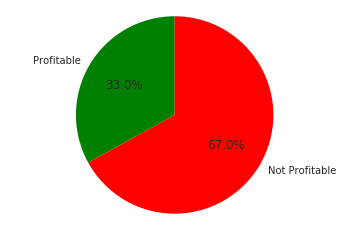

In [8]:
labels="Profitable","Not Profitable"
sizes=[sum(valid_data_models["is_profitable"]==1),sum(valid_data_models["is_profitable"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**Only about 33% of the movies are "profitable"**

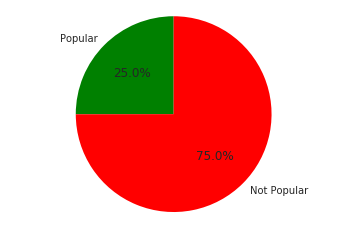

In [9]:
labels="Popular","Not Popular"
sizes=[sum(valid_data_models["is_popular"]==1),sum(valid_data_models["is_popular"]==0)]
colors=["green","red"]
plt.pie(sizes, labels=labels, colors=colors,
        autopct='%1.1f%%',startangle=90)
 
plt.axis('equal')
plt.show()

**About 25% of the movies are "popular" **

# 4) Regression and Classification Models

**We would be performing the following methods to understand and predict Profitability and Popularity of movies**

1. Multi Linear Regression
2. Logistic Regression
3. SVM
4. Decision Tree/Classification Tree
5. Random Forest
6. XGBoost

# 4.1  Regression and Classification for PROFITABILITY

# 4.1.1 Multi-Linear Regression

In [10]:
import statsmodels.api as sm
X=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","is_popular"],axis=1)
Y=valid_data_models["revenue"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     135.0
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:57:37   Log-Likelihood:                -41447.
No. Observations:                2062   AIC:                         8.297e+04
Df Residuals:                    2025   BIC:                         8.318e+04
Df Model:                          37                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
budget                 3.2241      0.081     39.944      0.000       3.066       3.382
runtime            -5.394e+04   1.77e+05     -0.305      0.760   -4.01e+05    2.93e+05
Animation           3.469e+07   1.59e+07      2.183      0.029    3.52e+06    6.58e+07
Crime              -9.451e+06   9.37e+06     -1.008      0.313   -2.78e+07    8.93e+06
History            -1.102e+07   1.53e+07     -0.721      0.471    -4.1e+07     1.9e+07
Horror              1.408e+07   1.17e+07      1.205      0.228   -8.84e+06     3.7e+07
Drama              -1.786e+07   7.44e+06     -2.400      0.016   -3.25e+07   -3.27e+06
Mystery            -1.335e+07   1.19e+07     -1.122      0.262   -3.67e+07    9.99e+06
Documentary        -1.164e+07   2.88e+07     -0.404      0.686   -6.82e+07    4.49e+07
Fantasy             -6.95e+05   1.12e+07     -0.062      0.950   -2.26e+07    2.12e+07
Action             -1.866e+07   8.03e+06     -2.324      0.020   -3.44e+07   -2.91e+06
Thriller            -1.11e+07   7.99e+06     -1.390      0.165   -2.68e+07    4.57e+06
Music               2.912e+06   1.86e+07      0.156      0.876   -3.36e+07    3.94e+07
Comedy              -1.65e+07   7.55e+06     -2.184      0.029   -3.13e+07   -1.69e+06
Family             -1.479e+07   1.36e+07     -1.086      0.278   -4.15e+07    1.19e+07
Romance             6.491e+06   8.56e+06      0.759      0.448   -1.03e+07    2.33e+07
Western            -9.109e+07   3.05e+07     -2.991      0.003   -1.51e+08   -3.14e+07
War                -1.475e+07   1.65e+07     -0.891      0.373   -4.72e+07    1.77e+07
Foreign            -3.674e+06    3.5e+07     -0.105      0.916   -7.23e+07     6.5e+07
Adventure           1.012e+07   9.38e+06      1.079      0.281   -8.28e+06    2.85e+07
Western Europe     -2.511e+07   7.85e+06     -3.201      0.001   -4.05e+07   -9.73e+06
Middle Africa       3.039e+07   1.33e+08      0.229      0.819    -2.3e+08    2.91e+08
Northern Africa    -5.677e+07   7.77e+07     -0.731      0.465   -2.09e+08    9.55e+07
Central America    -2.812e+07   3.98e+07     -0.706      0.480   -1.06e+08       5e+07
North America      -2.139e+07    1.3e+07     -1.645      0.100   -4.69e+07     4.1e+06
Eastern Asia        5.222e+05   1.58e+07      0.033      0.974   -3.05e+07    3.15e+07
South-Eastern Asia  1.408e+07   3.15e+07      0.447      0.655   -4.76e+07    7.58e+07
Central Asia        1.267e-08   8.82e-08      0.144      0.886    -1.6e-07    1.86e-07
Western Asia       -1.463e+07   4.53e+07     -0.323      0.747   -1.03e+08    7.41e+07
Eastern Europe     -2.267e+07   1.44e+07     -1.576      0.115   -5.09e+07    5.53e+06
Oceania            -6.074e+07   1.85e+07     -3.275      0.001   -9.71e+07   -2.44e+07
Southern Africa    -9.605e-07   5.05e-07     -1.903      0.057   -1.95e-06    2.94e-08
Southern Asia       2.661e+06   1.42e+

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [11]:
from sklearn.cross_validation import train_test_split
x=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y=valid_data_models["is_profitable"]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [12]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be PROFITABLE.**

In [13]:
def prof_train_acc_score(model):
    return np.mean(cross_val_score(model,x_train,y_train,cv=k_fold,scoring="accuracy"))
def prof_test_acc_score(model):
    return accuracy_score(y_test, model.predict(x_test))

def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_test,model_used.predict(x_test))
    col=["Predicted Not-Profitable","Predicted Profitable"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Profitable","Predicted Profitable"]
    cm.index=["Actual Not-Profitable","Actual Profitable"]
    #cm[col]=np(cm[col])
    return cm

def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.predict_proba(x_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_test,model.decision_function(x_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 4.1.2 Classification Methods

**Logistic regression**

In [14]:

log_reg=LogisticRegression(penalty="l1")
log_reg.fit(x_train,y_train)
predicted=log_reg.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(log_reg)))
print("Test accuracy: " + str(prof_test_acc_score(log_reg)))
confusion_matrix_model(log_reg)

In-sample accuracy: 0.657373123331
Test accuracy: 0.673123486683


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,270,6
Actual Profitable,129,8


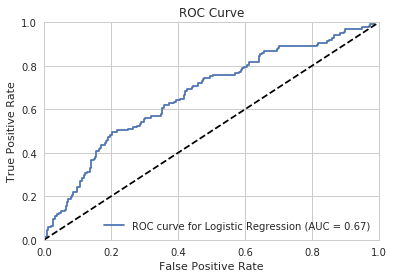

In [15]:
plt_roc_curve("Logistic Regression",log_reg,has_proba=True)

**SVM**

In [16]:
from sklearn import svm
SVM=svm.LinearSVC()
SVM.fit(x_train,y_train)
predicted=SVM.predict(x_test)

print("In-sample accuracy: " + str(prof_train_acc_score(SVM)))
print("Test accuracy: " + str(prof_test_acc_score(SVM)))
confusion_matrix_model(SVM)

In-sample accuracy: 0.53848392742
Test accuracy: 0.501210653753


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,128,148
Actual Profitable,58,79


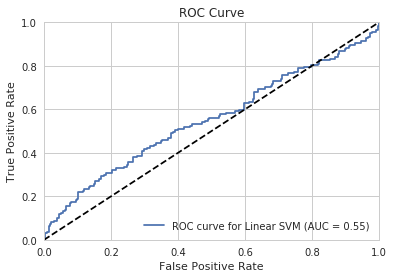

In [17]:
plt_roc_curve("Linear SVM",SVM,has_proba=False)

**KNN**

In [18]:
KNN=KNeighborsClassifier(n_neighbors=170)
KNN.fit(x_train,y_train)
predicted=KNN.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(KNN)))
print("Test accuracy: " + str(prof_test_acc_score(KNN)))
confusion_matrix_model(KNN)

In-sample accuracy: 0.670100396058
Test accuracy: 0.668280871671


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,276,0
Actual Profitable,137,0


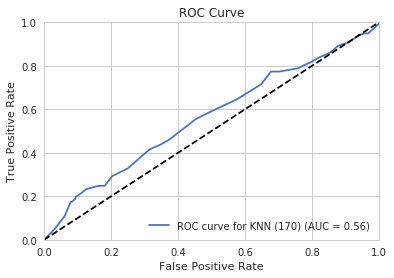

In [19]:
plt_roc_curve("KNN (170)",KNN,has_proba=True)

**Decision Tree/Classification Tree**

In [20]:
Dec_tree=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree.fit(x_train,y_train)
predicted=Dec_tree.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(Dec_tree)))
print("Test accuracy: " + str(prof_test_acc_score(Dec_tree)))
confusion_matrix_model(Dec_tree)

In-sample accuracy: 0.664025052961
Test accuracy: 0.670702179177


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,269,7
Actual Profitable,129,8


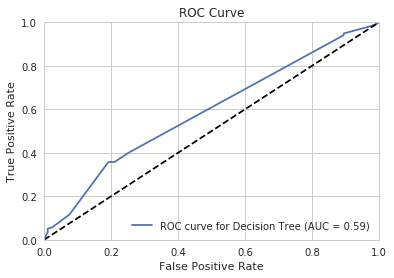

In [21]:
plt_roc_curve("Decision Tree",Dec_tree,has_proba=True)

**Random Forest**

In [22]:
ranfor = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor = ranfor.fit(x_train,y_train)
predicted=ranfor.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(ranfor)))
print("Test accuracy: " + str(prof_test_acc_score(ranfor)))
confusion_matrix_model(ranfor)

In-sample accuracy: 0.677986552455
Test accuracy: 0.677966101695


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,274,2
Actual Profitable,131,6


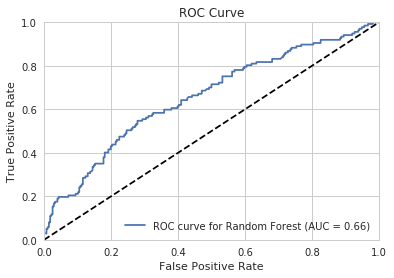

In [23]:
plt_roc_curve("Random Forest",ranfor,has_proba=True)

**XGboosting**

In [24]:
xgclass = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(x_train, y_train)
predicted=xgclass.predict(x_test)
print("In-sample accuracy: " + str(prof_train_acc_score(xgclass)))
print("Test accuracy: " + str(prof_test_acc_score(xgclass)))
confusion_matrix_model(xgclass)

In-sample accuracy: 0.681007644837
Test accuracy: 0.682808716707


,Predicted Not-Profitable,Predicted Profitable
Actual Not-Profitable,272,4
Actual Profitable,127,10


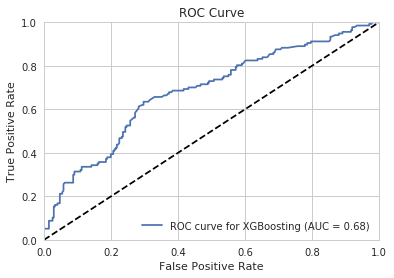

In [25]:
plt_roc_curve("XGBoosting",xgclass,has_proba=True)

# 4.1.3 Results for Classification methods for profitability

In [26]:
Classifiers=["Logistic Regression","Support Vector Machine","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[prof_train_acc_score(x) for x in [log_reg,SVM,KNN,Dec_tree,ranfor,xgclass]]
test_acc=[prof_test_acc_score(x) for x in [log_reg,SVM,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_prob=[aucscore(x,has_proba=True) for x in [log_reg,KNN,Dec_tree,ranfor,xgclass]]
auc_scores_noprob=[aucscore(x,has_proba=False) for x in [SVM]]
auc_scores=auc_scores_prob[:1] + auc_scores_noprob + auc_scores_prob[1:]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC"]
profit_results = pd.DataFrame(columns=cols)
profit_results["Classifier"]=Classifiers
profit_results["In-sample Accuracy"]=in_sample_acc
profit_results["Test Accuracy"]=test_acc
profit_results["AUC"]=auc_scores
profit_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC
0,Logistic Regression,0.657981,0.673123,0.670449
1,Support Vector Machine,0.456566,0.501211,0.550487
2,K-Nearest Neighbours,0.670100,0.668281,0.561092
3,Decision Tree,0.664025,0.670702,0.588477
4,Random Forest,0.677987,0.677966,0.657331
5,XGBoost,0.681008,0.682809,0.682588


# 4.2  Regression and Classification for POPULARITY

# 4.2.1 Multi-Linear Regression

In [27]:
X=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
Y=valid_data_models["Weighted_ratings"]

model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       Weighted_ratings   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     2992.
Date:                Tue, 03 Apr 2018   Prob (F-statistic):               0.00
Time:                        21:57:44   Log-Likelihood:                -2468.5
No. Observations:                2062   AIC:                             5009.
Df Residuals:                    2026   BIC:                             5212.
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
budget             -1.297e-09   4.97e-10     -2.609      0.009   -2.27e-09   -3.22e-10
runtime                0.0422      0.001     75.386      0.000       0.041       0.043
Animation              0.8879      0.096      9.244      0.000       0.700       1.076
Crime                  0.0263      0.058      0.454      0.650      -0.087       0.140
History               -0.3401      0.094     -3.618      0.000      -0.524      -0.156
Horror                 0.8586      0.070     12.347      0.000       0.722       0.995
Drama                  0.3761      0.045      8.329      0.000       0.288       0.465
Mystery                0.0541      0.073      0.737      0.461      -0.090       0.198
Documentary            1.2349      0.176      7.029      0.000       0.890       1.580
Fantasy                0.1459      0.069      2.121      0.034       0.011       0.281
Action                 0.3324      0.049      6.786      0.000       0.236       0.428
Thriller               0.3989      0.048      8.225      0.000       0.304       0.494
Music                  0.0660      0.115      0.574      0.566      -0.159       0.291
Comedy                 0.7988      0.043     18.536      0.000       0.714       0.883
Family                 0.3689      0.084      4.408      0.000       0.205       0.533
Romance                0.0624      0.053      1.182      0.237      -0.041       0.166
Western                0.1535      0.188      0.817      0.414      -0.215       0.522
War                   -0.0218      0.102     -0.214      0.831      -0.222       0.178
Foreign               -0.1732      0.216     -0.802      0.423      -0.597       0.250
Adventure              0.0463      0.058      0.799      0.424      -0.067       0.160
Western Europe         0.1160      0.048      2.399      0.017       0.021       0.211
Middle Africa         -0.6465      0.820     -0.788      0.431      -2.255       0.962
Northern Africa       -0.7591      0.479     -1.585      0.113      -1.698       0.180
Central America       -0.0717      0.246     -0.292      0.771      -0.554       0.410
North America          0.0941      0.080      1.174      0.241      -0.063       0.251
Eastern Asia          -0.0402      0.097     -0.413      0.680      -0.231       0.151
South-Eastern Asia    -0.3814      0.194     -1.966      0.049      -0.762      -0.001
Central Asia        6.676e-16   6.35e-16      1.051      0.293   -5.78e-16    1.91e-15
Western Asia           0.3825      0.279      1.370      0.171      -0.165       0.930
Eastern Europe         0.4133      0.088      4.683      0.000       0.240       0.586
Oceania                0.1060      0.114      0.926      0.355      -0.118       0.330
Southern Africa     6.353e-15   6.82e-15      0.931      0.352   -7.03e-15    1.97e-14
Southern Asia         -1.3025      0.0

**We will first split our training and test set (20%)**

**We will also remove variables that we do not know before a movie is released (e.g profitability, vote counts etc)**

In [28]:
x_pop=valid_data_models.drop(["is_profitable","Profitability","revenue","popularity","vote_average","vote_count","Weighted_ratings","is_popular"],axis=1)
y_pop=valid_data_models["is_popular"]
x_pop_train,x_pop_test,y_pop_train,y_pop_test=train_test_split(x_pop,y_pop,test_size=0.2,random_state=0)

**We will use 5-fold cross validation**

In [29]:
from sklearn.model_selection import KFold
k_fold = KFold(n_splits=5, shuffle=True, random_state=0)

**We will create functions to calculate the In-sample accuracy, Test accuracy and to plot our ROC curve and confusion matrix for classifying whether a movie would be POPULAR.**

In [30]:
def pop_train_acc_score(model):
    return np.mean(cross_val_score(model,x_pop_train,y_pop_train,cv=k_fold,scoring="accuracy"))
def pop_test_acc_score(model):
    return accuracy_score(y_pop_test, model.predict(x_pop_test))
def confusion_matrix_model(model_used):
    cm=confusion_matrix(y_pop_test,model_used.predict(x_pop_test))
    col=["Predicted Not-Popular","Predicted Popular"]
    cm=pd.DataFrame(cm)
    cm.columns=["Predicted Not-Popular","Predicted Popular"]
    cm.index=["Actual Not-Popular","Actual Popular"]
    #cm[col]=np(cm[col])
    return cm

def aucscore(model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    return auc
def plt_roc_curve(name,model,has_proba=True):
    if has_proba:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.predict_proba(x_pop_test)[:,1])
    else:
        fpr,tpr,thresh=skplt.metrics.roc_curve(y_pop_test,model.decision_function(x_pop_test))
    x=fpr
    y=tpr
    auc= skplt.metrics.auc(x,y)
    plt.plot(x,y,label='ROC curve for %s (AUC = %0.2f)' % (name, auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim((0,1))
    plt.ylim((0,1))
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

# 4.2.2 Classification Methods

**Logistic regression**

In [31]:
from sklearn.metrics import accuracy_score
log_reg_pop=LogisticRegression(penalty="l1")
log_reg_pop.fit(x_pop_train,y_pop_train)
predicted=log_reg_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(log_reg_pop)))
print("Test accuracy: " + str(pop_test_acc_score(log_reg_pop)))
confusion_matrix_model(log_reg_pop)

In-sample accuracy: 0.793220963434
Test accuracy: 0.769975786925


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,288,14
Actual Popular,81,30


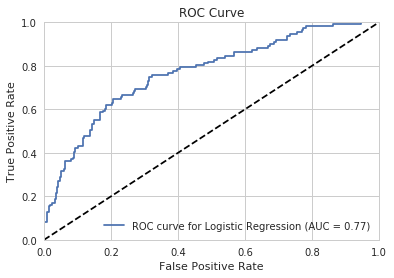

In [32]:
plt_roc_curve("Logistic Regression",log_reg_pop,has_proba=True)

**SVM**

In [33]:
from sklearn import svm
SVM_pop=svm.LinearSVC()
SVM_pop.fit(x_pop_train,y_pop_train)
predicted=SVM_pop.predict(x_pop_test)

print("In-sample accuracy: " + str(pop_train_acc_score(SVM_pop)))
print("Test accuracy: " + str(pop_test_acc_score(SVM_pop)))
confusion_matrix_model(SVM_pop)

In-sample accuracy: 0.586344294004
Test accuracy: 0.750605326877


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,297,5
Actual Popular,98,13


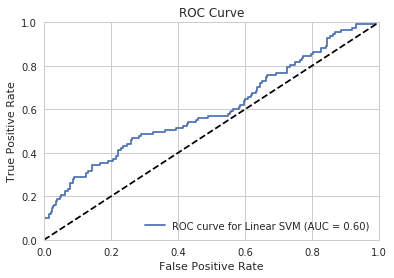

In [34]:
plt_roc_curve("Linear SVM",SVM_pop,has_proba=False)

**KNN**

In [35]:
KNN_pop=KNeighborsClassifier(n_neighbors=170)
KNN_pop.fit(x_pop_train,y_pop_train)
predicted=KNN_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(KNN_pop)))
print("Test accuracy: " + str(pop_test_acc_score(KNN_pop)))
confusion_matrix_model(KNN_pop)

In-sample accuracy: 0.782300819748
Test accuracy: 0.762711864407


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,290,12
Actual Popular,86,25


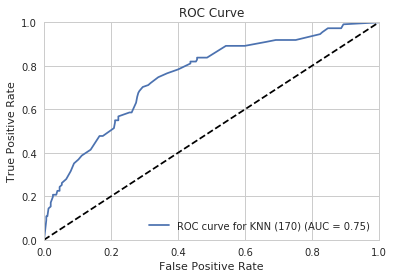

In [36]:
plt_roc_curve("KNN (170)",KNN_pop,has_proba=True)

**Decision Tree/Classification Tree**

In [37]:
Dec_tree_pop=DecisionTreeClassifier(max_depth=4,random_state=5)
Dec_tree_pop.fit(x_pop_train,y_pop_train)
predicted=Dec_tree_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(Dec_tree_pop)))
print("Test accuracy: " + str(pop_test_acc_score(Dec_tree_pop)))
confusion_matrix_model(Dec_tree_pop)

In-sample accuracy: 0.7804807958
Test accuracy: 0.765133171913


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,284,18
Actual Popular,79,32


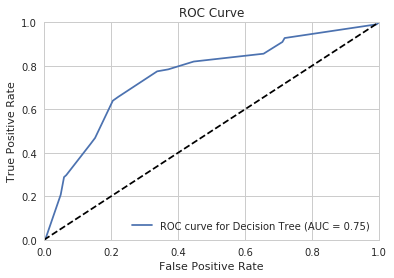

In [38]:
plt_roc_curve("Decision Tree",Dec_tree_pop,has_proba=True)

**Random Forest**

In [39]:
ranfor_pop = RandomForestClassifier(n_estimators=50, max_features='sqrt',max_depth=6,random_state=10)
ranfor_pop = ranfor_pop.fit(x_pop_train,y_pop_train)
predicted=ranfor_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(ranfor_pop)))
print("Test accuracy: " + str(pop_test_acc_score(ranfor_pop)))
confusion_matrix_model(ranfor_pop)

In-sample accuracy: 0.787755365202
Test accuracy: 0.765133171913


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,291,11
Actual Popular,86,25


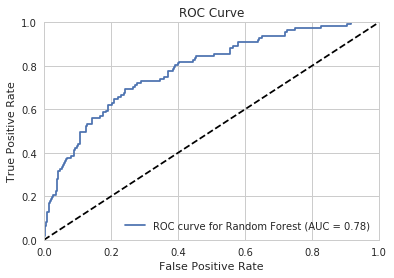

In [40]:
plt_roc_curve("Random Forest",ranfor_pop,has_proba=True)

**XGBoosting**

In [41]:
xgclass_pop = xgb.XGBClassifier(max_depth=3, n_estimators=300, learning_rate=0.01).fit(x_pop_train, y_pop_train)
predicted=xgclass_pop.predict(x_pop_test)
print("In-sample accuracy: " + str(pop_train_acc_score(xgclass_pop)))
print("Test accuracy: " + str(pop_test_acc_score(xgclass_pop)))
confusion_matrix_model(xgclass_pop)

In-sample accuracy: 0.795024408216
Test accuracy: 0.772397094431


,Predicted Not-Popular,Predicted Popular
Actual Not-Popular,284,18
Actual Popular,76,35


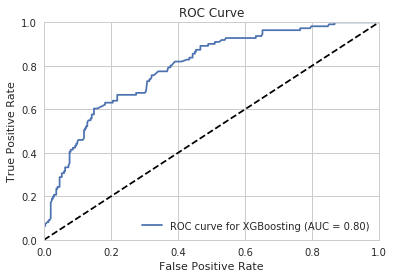

In [42]:
plt_roc_curve("XGBoosting",xgclass_pop,has_proba=True)

# 4.2.3 Results for Classification methods for popularity

In [43]:
Classifiers=["Logistic Regression","Support Vector Machine","K-Nearest Neighbours","Decision Tree","Random Forest","XGBoost"]
in_sample_acc=[pop_train_acc_score(x) for x in [log_reg_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
test_acc=[pop_test_acc_score(x) for x in [log_reg_pop,SVM_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_prob=[aucscore(x,has_proba=True) for x in [log_reg_pop,KNN_pop,Dec_tree_pop,ranfor_pop,xgclass_pop]]
auc_scores_noprob=[aucscore(x,has_proba=False) for x in [SVM_pop]]
auc_scores=auc_scores_prob[:1] + auc_scores_noprob + auc_scores_prob[1:]
cols=["Classifier","In-sample Accuracy","Test Accuracy","AUC"]
popularity_results = pd.DataFrame(columns=cols)
popularity_results["Classifier"]=Classifiers
popularity_results["In-sample Accuracy"]=in_sample_acc
popularity_results["Test Accuracy"]=test_acc
popularity_results["AUC"]=auc_scores
popularity_results

,Classifier,In-sample Accuracy,Test Accuracy,AUC
0,Logistic Regression,0.793221,0.769976,0.768182
1,Support Vector Machine,0.670760,0.750605,0.600501
2,K-Nearest Neighbours,0.782301,0.762712,0.751745
3,Decision Tree,0.780481,0.765133,0.752953
4,Random Forest,0.787755,0.765133,0.783456
5,XGBoost,0.795024,0.772397,0.795030
